# Negative-Binomial Plots of Number of Secondary Cases

This notebook contains the code for plotting the distribution of number of secondary cases along with their Negative-Binomial fits. As such, the code still requires a bit of manual adaptation for each experiment. So the code here corresponds to the code to generate the plots in the paper.


In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import itertools
import numpy as np
from scipy import stats as sps
import scipy.optimize
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [51]:
from lib.calibrationSettings import (
    calibration_lockdown_dates, 
    calibration_states,
)
from lib.experiment import load_summary
from lib import plot as plot_lib
from lib import rt_nbinom  # Module for NB fit of Rt/kt

---

## Experiment in CH-BE for continued lockdown extended for 4 weeks

In [10]:
summary_name = 'continued-lockdown-CH-BE-extended_lockdown_weeks=4.pk'

# Load the experiment summary
result = load_summary(summary_name)

# Extract the lockdown start time for the country
country_code = result.metadata.country
lockdown = calibration_lockdown_dates[country_code]
print((f"{country_code}: simulation starts on {result.metadata.start_date}, "
       f"lockdown starts on {lockdown['start']}"))

CH: simulation starts on 2020-03-06, lockdown starts on 2020-03-16


In [23]:
sim = result.summary

t0_range = [
     0.0 * 24,    # the week before lockdown
    11.0 * 24,    # right after start of lockdown
    38.0 * 24     # right after end of lockdown
]
interval_range = [(t0, t0 + 10. * 24) for t0 in t0_range]
rand_rep_range = range(result.metadata.random_repeats)

# Print intervals in datetime format
def days_to_datetime(arr, start_date):
    return pd.to_datetime(arr * 60 * 60 + pd.Timestamp(start_date).timestamp(), unit='s')
for t0, t1 in interval_range:
    print(days_to_datetime(np.array([t0, t1]), result.metadata.start_date))

res_data = []
for r, (t0, t1) in itertools.product(rand_rep_range, interval_range):
        data = rt_nbinom.get_sec_cases_in_window(sim, r, t0, t1)
        fitter = rt_nbinom.NegativeBinomialFitter()
        fitter.fit(data)
        print(f"---> r={r}, time=[{t0:>6.1f}, {t1:>6.1f}] - Rt: {fitter.r_:.2f} kt: {fitter.k_:.2f}")
        res_data.append({'r': r, 't0': t0, 't1': t1, 
                         'Rt': fitter.r_, 'kt': fitter.k_, 
                         'num_sec_cases': data})

DatetimeIndex(['2020-03-06', '2020-03-16'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2020-03-17', '2020-03-27'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2020-04-13', '2020-04-23'], dtype='datetime64[ns]', freq=None)
---> r=0, time=[   0.0,  240.0] - Rt: 2.57 kt: 1.26
---> r=0, time=[ 264.0,  504.0] - Rt: 0.41 kt: 0.40
---> r=0, time=[ 912.0, 1152.0] - Rt: 3.27 kt: 0.20
---> r=1, time=[   0.0,  240.0] - Rt: 2.40 kt: 1.23
---> r=1, time=[ 264.0,  504.0] - Rt: 0.44 kt: 0.59
---> r=1, time=[ 912.0, 1152.0] - Rt: 4.55 kt: 0.19
---> r=2, time=[   0.0,  240.0] - Rt: 1.96 kt: 0.71
---> r=2, time=[ 264.0,  504.0] - Rt: 0.53 kt: 0.60
---> r=2, time=[ 912.0, 1152.0] - Rt: 2.91 kt: 0.29
---> r=3, time=[   0.0,  240.0] - Rt: 2.39 kt: 2.07
---> r=3, time=[ 264.0,  504.0] - Rt: 0.42 kt: 0.87
---> r=3, time=[ 912.0, 1152.0] - Rt: 4.16 kt: 0.20
---> r=4, time=[   0.0,  240.0] - Rt: 2.42 kt: 1.50
---> r=4, time=[ 264.0,  504.0] - Rt: 0.47 kt: 0.61
---> r=4, time=[ 912.0, 1152.0] - R

In [24]:
df = pd.DataFrame(res_data)

# Ignore simulations with not enough data for fitting
df['len_data'] = df['num_sec_cases'].apply(len)
df['sum_data'] = df['num_sec_cases'].apply(sum)
df.loc[(df['len_data'] < 10) + (df['sum_data'] < 10),'kt'] = np.nan
df.loc[(df['len_data'] == 0),'Rt'] = 0.0  # if no cases observed

# Compute NB parameters 
df['param_n'] = df['kt']
df['param_p'] = df['kt'] / (df['kt'] + df['Rt'])

# Computer NB PMF
x_range = np.arange(0, 20)
df['nbinom_pmf'] = df.apply(lambda row: sps.nbinom.pmf(x_range, n=row['param_n'], p=row['param_p']), axis=1)

# Aggregate results over all random repeats
df_agg = df.groupby('t0').agg({'nbinom_pmf': list, 'Rt': ['mean', 'std'], 'kt': ['mean', 'std']})

df_agg

nbinom_pmf        Rt            \
                                                    list      mean       std   
t0                                                                             
0.0    [[0.24627024618045187, 0.20833522411333788, 0....  2.573168  0.364284   
264.0  [[0.7537649227104517, 0.1527761063815198, 0.05...  0.460616  0.060506   
912.0  [[0.5652025401048575, 0.10645002043487935, 0.0...  3.068966  1.338776   

             kt            
           mean       std  
t0                         
0.0    1.221556  0.295100  
264.0  0.573173  0.149848  
912.0  0.192811  0.090692

In [38]:
plotter = plot_lib.Plotter()
plotter.plot_nbinom_distributions(result=result,
                                  x_range=x_range,
                                  t0_range=[0.0 * 24,   # the week before lockdown
                                            11.0 * 24,  # right after start of lockdown
                                            38.0 * 24   # right after end of lockdown
                                  ],
                                  window_size=10.0*24,
                                  label_range=['pre-lockdown',
                                               'in-lockdown',
                                               'post-lockdown'],
                                   ymax=0.77,
                                   filename=summary_name.rstrip('.pk'))

# Crop pdf margins
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-0-pre-lockdown.pdf
Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-1-in-lockdown.pdf
Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-2-post-lockdown.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


In [41]:
plt.rcParams.update(SIGCONF_RCPARAMS_TRIPLE)

label_range = ['pre-lockdown', 'in-lockdown', 'post-lockdown']

for i, (t0, label) in enumerate(zip(t0_range, label_range)):

    fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE_TRIPLE)
    # Extract data for the plot
    row_df = df.loc[df.t0 == t0]
    row_df_agg = df_agg.loc[t0]
    y_nbinom = np.nanmean(np.vstack(row_df_agg['nbinom_pmf']), axis=0)
    # Plot histogram
    plt.hist(np.hstack(row_df['num_sec_cases']),
             bins=x_range, density=True,
             color='darkgray',
             align='left', width=0.8,
             label='Empirical')
    # Plot NB pmf
    plt.plot(x_range, y_nbinom, 
             color='k',
             label='NB')
    # Write estimates in text
    text_x = 0.25
    text_y = 0.18
    plt.text(text_x,       text_y + 0.18, transform=ax.transAxes,
             s=r'$R_t ~=~' + f"{row_df_agg['Rt']['mean']:.2f} \pm ({row_df_agg['Rt']['std']:.2f})$")
    plt.text(text_x + .020, text_y, transform=ax.transAxes,
             s=r'$k_t ~=~' + f"{row_df_agg['kt']['mean']:.2f} \pm ({row_df_agg['kt']['std']:.2f})$")
    # Set layout and labels
    plt.ylim(top=0.77)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.xlabel('Number of Secondary Cases')
    plt.ylabel('Probability')
    plt.legend(loc='upper right')
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Save figure
    filename = f"plots/prob-secondaryCases-{summary_name.rstrip('.pk')}-{i}-{label}"
    print('Save:', filename)
    plt.savefig(filename + '.pdf')
    plt.close()

# Crop pdf margins
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-0-pre-lockdown
Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-1-in-lockdown
Save: plots/prob-secondaryCases-continued-lockdown-CH-BE-extended_lockdown_weeks=4-2-post-lockdown
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


---

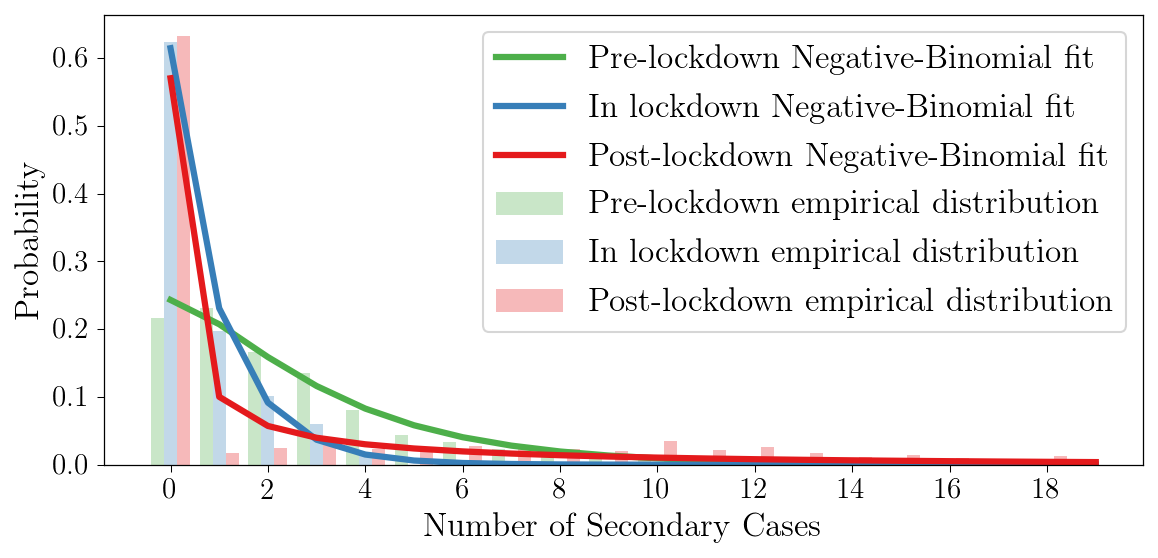

In [88]:
colors = [
    '#4daf4a',
    '#377eb8',
    '#e41a1c',
]

plt.figure(figsize=(8, 4))

plt.hist(
    x=[np.hstack(df.loc[df.t0 == t0 * 24]['num_sec_cases']) for t0 in t0_range],
    bins=x_range, density=True,
    color=colors[:len(t0_range)], alpha=0.3, 
    align='left', width=0.8/3,
    label=[
        'Pre-lockdown empirical distribution',
        'In lockdown empirical distribution',
        'Post-lockdown empirical distribution'
])

plt.plot(np.nanmean(np.vstack(df_agg['nbinom_pmf'].iloc[0]), axis=0), 
         color=colors[0], lw=3,
         label='Pre-lockdown Negative-Binomial fit')
plt.plot(np.nanmean(np.vstack(df_agg['nbinom_pmf'].iloc[1]), axis=0), 
         color=colors[1], lw=3,
         label='In lockdown Negative-Binomial fit')
plt.plot(np.nanmean(np.vstack(df_agg['nbinom_pmf'].iloc[2]), axis=0), 
         color=colors[2], lw=3,
         label='Post-lockdown Negative-Binomial fit')

plt.xticks(np.arange(0, 20, 2))
plt.xlabel('Number of Secondary Cases')
plt.ylabel('Probability')
plt.legend()
plt.tight_layout();
plt.savefig(f'plots/prob-secondaryCases-{summary_name}-single-plot.pdf')